<a href="https://colab.research.google.com/github/sayakpaul/TF-2.0-Hacks/blob/master/Transfer_Learning_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Which GPU am I using?
!nvidia-smi

In [0]:
# Import TensorFlow and TFHub
import tensorflow as tf
import tensorflow_hub as hub

print(tf.__version__)

2.2.0-rc2


In [0]:
# Install wandb and authorize
!pip install wandb -q
import wandb
from wandb.keras import WandbCallback
wandb.login()

In [0]:
# We are not going to sync up the .h5 files with wandb
%env WANDB_IGNORE_GLOBS *.h5

env: WANDB_IGNORE_GLOBS=*.h5


In [0]:
# TensorFlow datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [0]:
# Other imports
import matplotlib.pyplot as plt
import time

In [0]:
# Available datasets
tfds.list_builders()[:10]

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'arc',
 'bair_robot_pushing_small',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum']

In [0]:
# Load up the cats vs. dogs dataset
(raw_train, raw_validation), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteG68MFS/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


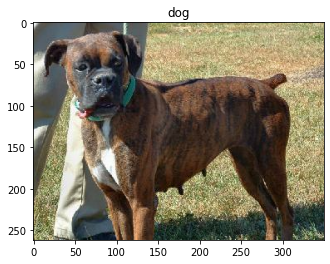

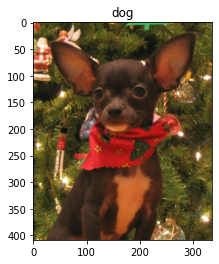

In [0]:
# Show two image from the train set
get_label_name = metadata.features['label'].int2str
for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [0]:
IMG_SIZE = 224 # All images will be resized to 224x224

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [0]:
# Preprocess the images
train = raw_train.map(format_example)
valid = raw_validation.map(format_example)

In [0]:
# Prepare batches of 32 and randomly shuffle the training images
AUTO = tf.data.experimental.AUTOTUNE
train_batches = train.shuffle(1024).repeat().batch(32).prefetch(AUTO)
valid_batches = valid.repeat().batch(32).prefetch(AUTO)

In [0]:
# Inspect the shapes
for (images, labels) in train_batches.take(1):
    pass
print(images.shape, labels.shape)

(32, 224, 224, 3) (32,)


In [0]:
# Calculate steps
train_x_batched = train.batch(32)
val_x_batched = valid.batch(32)

def calculate_steps(dataset):
    steps = 0
    for _ in dataset:
        steps += 1
    return steps

TRAIN_STEPS = calculate_steps(train_x_batched)
VALID_STEPS = calculate_steps(val_x_batched)
print(TRAIN_STEPS)
print(VALID_STEPS)

582
146


In [0]:
def get_training_model(url, trainable=False):
    # Load the respective EfficientNet model but exclude the classification layers
    extractor = hub.KerasLayer(url, input_shape=(IMG_SIZE, IMG_SIZE, 3), trainable=trainable)
    
    # Construct the head of the model that will be placed on top of the
    # the base model
    model = tf.keras.models.Sequential([
        extractor,
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1)
    ])
    
    # Compile and return the model
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                          optimizer="adam",
                          metrics=["accuracy"])
    
    return model

In [0]:
def train_utils(model, run_name, model_name):
    # Initialize wandb
    wandb.init(project="efficientnet-tl", entity="sayakpaul", id=run_name)

    # Train the model
    start = time.time()
    model.fit(train_batches,
        steps_per_epoch=TRAIN_STEPS,
        validation_data=valid_batches,
        validation_steps=TRAIN_STEPS,
        epochs=10,
        callbacks=[WandbCallback()])
    end = time.time() - start
    print("model training time", end)
    wandb.log({"training_time":end})

    # Serialize the model to see the footprint
    model.save(model_name)

In [0]:
# B0 model
b0_model = get_training_model("https://tfhub.dev/google/efficientnet/b0/feature-vector/1")
train_utils(b0_model, "b0", "b0.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Epoch 1/10
582/582 [==============================] - 115s 198ms/step - loss: 0.4668 - accuracy: 0.7468 - val_loss: 0.4110 - val_accuracy: 0.7672
Epoch 2/10
582/582 [==============================] - 117s 201ms/step - loss: 0.4154 - accuracy: 0.7825 - val_loss: 0.4090 - val_accuracy: 0.7577
Epoch 3/10
582/582 [==============================] - 116s 199ms/step - loss: 0.3993 - accuracy: 0.7911 - val_loss: 0.3926 - val_accuracy: 0.7784
Epoch 4/10
582/582 [==============================] - 116s 199ms/step - loss: 0.3871 - accuracy: 0.7992 - val_loss: 0.3937 - val_accuracy: 0.7863
Epoch 5/10
582/582 [==============================] - 116s 200ms/step - loss: 0.3708 - accuracy: 0.8116 - val_loss: 0.3881 - val_accuracy: 0.7917
Epoch 6/10
582/582 [==============================] - 116s 200ms/step - loss: 0.3572 - accuracy: 0.8186 - val_loss: 0.3940 - val_accuracy: 0.7951
Epoch 7/10
582/582 [==============================] - 116s 200ms/step - loss: 0.3495 - accuracy: 0.8235 - val_loss: 0.3941 -

In [0]:
# Check the footprint
ls -lh b0.h5

-rw-r--r-- 1 root root 18M Apr 11 14:19 b0.h5


In [0]:
# B1 model
b1_model = get_training_model("https://tfhub.dev/google/efficientnet/b1/feature-vector/1")
train_utils(b1_model, "b1", "b1.h5")

Epoch 1/10
582/582 [==============================] - 150s 258ms/step - loss: 2.9432 - accuracy: 0.5107 - val_loss: 0.6902 - val_accuracy: 0.5335
Epoch 2/10
582/582 [==============================] - 154s 265ms/step - loss: 0.6848 - accuracy: 0.5425 - val_loss: 0.6845 - val_accuracy: 0.5505
Epoch 3/10
582/582 [==============================] - 153s 263ms/step - loss: 0.6679 - accuracy: 0.5527 - val_loss: 0.6552 - val_accuracy: 0.5477
Epoch 4/10
582/582 [==============================] - 153s 263ms/step - loss: 0.6600 - accuracy: 0.5576 - val_loss: 0.6719 - val_accuracy: 0.5542
Epoch 5/10
582/582 [==============================] - 153s 263ms/step - loss: 0.7288 - accuracy: 0.5633 - val_loss: 0.6452 - val_accuracy: 0.5541
Epoch 6/10
582/582 [==============================] - 152s 261ms/step - loss: 0.6458 - accuracy: 0.5667 - val_loss: 0.6819 - val_accuracy: 0.5563
Epoch 7/10
582/582 [==============================] - 150s 258ms/step - loss: 0.6528 - accuracy: 0.5697 - val_loss: 0.6454 -

In [0]:
# Check the footprint
ls -lh b1.h5

-rw-r--r-- 1 root root 28M Apr 11 14:45 b1.h5


In [0]:
# B2 model
b2_model = get_training_model("https://tfhub.dev/google/efficientnet/b2/feature-vector/1")
train_utils(b2_model, "b2", "b2.h5")

Epoch 1/10
582/582 [==============================] - 156s 269ms/step - loss: 0.5641 - accuracy: 0.6797 - val_loss: 0.4957 - val_accuracy: 0.7336
Epoch 2/10
582/582 [==============================] - 159s 274ms/step - loss: 0.5046 - accuracy: 0.7194 - val_loss: 0.4866 - val_accuracy: 0.6895
Epoch 3/10
582/582 [==============================] - 159s 273ms/step - loss: 0.5164 - accuracy: 0.7310 - val_loss: 0.4611 - val_accuracy: 0.7293
Epoch 4/10
582/582 [==============================] - 158s 271ms/step - loss: 0.4734 - accuracy: 0.7439 - val_loss: 0.4647 - val_accuracy: 0.7306
Epoch 5/10
582/582 [==============================] - 159s 273ms/step - loss: 0.4911 - accuracy: 0.7512 - val_loss: 0.4548 - val_accuracy: 0.7381
Epoch 6/10
582/582 [==============================] - 158s 271ms/step - loss: 0.4535 - accuracy: 0.7503 - val_loss: 0.4500 - val_accuracy: 0.7383
Epoch 7/10
582/582 [==============================] - 158s 272ms/step - loss: 0.4403 - accuracy: 0.7562 - val_loss: 0.4531 -

In [0]:
# Check the footprint
ls -lh b2.h5

-rw-r--r-- 1 root root 33M Apr 11 15:14 b2.h5


In [0]:
# B3 model
b3_model = get_training_model("https://tfhub.dev/google/efficientnet/b3/feature-vector/1")
train_utils(b3_model, "b3", "b3.h5")

Epoch 1/10
582/582 [==============================] - 202s 347ms/step - loss: 0.7288 - accuracy: 0.5790 - val_loss: 0.6265 - val_accuracy: 0.5932
Epoch 2/10
582/582 [==============================] - 206s 353ms/step - loss: 0.6243 - accuracy: 0.5984 - val_loss: 0.6180 - val_accuracy: 0.5989
Epoch 3/10
582/582 [==============================] - 206s 354ms/step - loss: 0.6136 - accuracy: 0.6105 - val_loss: 0.6130 - val_accuracy: 0.6115
Epoch 4/10
582/582 [==============================] - 204s 351ms/step - loss: 0.6096 - accuracy: 0.6150 - val_loss: 0.6110 - val_accuracy: 0.5913
Epoch 5/10
582/582 [==============================] - 204s 351ms/step - loss: 0.6044 - accuracy: 0.6209 - val_loss: 0.6097 - val_accuracy: 0.5973
Epoch 6/10
582/582 [==============================] - 202s 348ms/step - loss: 0.5934 - accuracy: 0.6322 - val_loss: 0.6100 - val_accuracy: 0.6238
Epoch 7/10
582/582 [==============================] - 205s 352ms/step - loss: 0.5913 - accuracy: 0.6295 - val_loss: 0.6037 -

In [0]:
# Check the footprint
ls -lh b3.h5

-rw-r--r-- 1 root root 44M Apr 11 15:54 b3.h5


Let's compare the performance with MobileNetV2. The first one would be without any fine-tuning.

In [0]:
# MobileNetV2 model
mbnet_v2 = get_training_model("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4")
train_utils(mbnet_v2, "mobilenet_v2_no_ft", "mobilenet_v2_no_ft.h5")

Epoch 1/10
582/582 [==============================] - 90s 154ms/step - loss: 0.1743 - accuracy: 0.9257 - val_loss: 0.1232 - val_accuracy: 0.9445
Epoch 2/10
582/582 [==============================] - 87s 149ms/step - loss: 0.1363 - accuracy: 0.9414 - val_loss: 0.1329 - val_accuracy: 0.9359
Epoch 3/10
582/582 [==============================] - 89s 153ms/step - loss: 0.1243 - accuracy: 0.9465 - val_loss: 0.1154 - val_accuracy: 0.9557
Epoch 4/10
582/582 [==============================] - 87s 150ms/step - loss: 0.1134 - accuracy: 0.9502 - val_loss: 0.1177 - val_accuracy: 0.9492
Epoch 5/10
582/582 [==============================] - 92s 158ms/step - loss: 0.1088 - accuracy: 0.9522 - val_loss: 0.1134 - val_accuracy: 0.9551
Epoch 6/10
582/582 [==============================] - 88s 150ms/step - loss: 0.1020 - accuracy: 0.9539 - val_loss: 0.1198 - val_accuracy: 0.9551
Epoch 7/10
582/582 [==============================] - 85s 147ms/step - loss: 0.0957 - accuracy: 0.9589 - val_loss: 0.1181 - val_ac

In [0]:
# Check the footprint
ls -lh mobilenet_v2_no_ft.h5

-rw-r--r-- 1 root root 11M Apr 11 16:09 mobilenet_v2_no_ft.h5


Let's fine-tune it now. We could not do the same for the EfficientNet family of models because it's currently not supported. To ensure the pre-trained weights do not get hurt during the beginning of the training, we will use an LR scheduler with ramp up (courtesy of [this notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_xception_fine_tuned_best.ipynb)). 

In [0]:
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

In [0]:
def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

1e-05 2.6384000000000004e-05


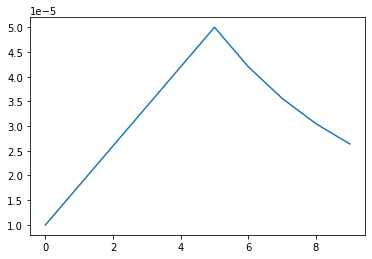

In [0]:
rng = [i for i in range(10)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

In [0]:
# MobileNetV2 model with fine-tuning
mbnet_v2 = get_training_model("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4", trainable=True)
train_utils(mbnet_v2, "mobilenet_v2_ft", "mobilenet_v2_ft.h5")

Epoch 1/10
582/582 [==============================] - 226s 388ms/step - loss: 0.2316 - accuracy: 0.9402 - val_loss: 0.2218 - val_accuracy: 0.9632
Epoch 2/10
582/582 [==============================] - 229s 393ms/step - loss: 0.1807 - accuracy: 0.9614 - val_loss: 0.1720 - val_accuracy: 0.9634
Epoch 3/10
582/582 [==============================] - 227s 391ms/step - loss: 0.1771 - accuracy: 0.9647 - val_loss: 0.2093 - val_accuracy: 0.9381
Epoch 4/10
582/582 [==============================] - 230s 396ms/step - loss: 0.1496 - accuracy: 0.9755 - val_loss: 0.2241 - val_accuracy: 0.9668
Epoch 5/10
582/582 [==============================] - 229s 393ms/step - loss: 0.1443 - accuracy: 0.9771 - val_loss: 0.2504 - val_accuracy: 0.9286
Epoch 6/10
582/582 [==============================] - 229s 393ms/step - loss: 0.1495 - accuracy: 0.9736 - val_loss: 0.1553 - val_accuracy: 0.9743
Epoch 7/10
582/582 [==============================] - 230s 395ms/step - loss: 0.1308 - accuracy: 0.9792 - val_loss: 0.2173 -

In [0]:
# Check the footprint
ls -lh mobilenet_v2_ft.h5

-rw-r--r-- 1 root root 29M Apr 11 16:50 mobilenet_v2_ft.h5
